In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from keras.models import load_model
from sklearn.metrics import log_loss
import json

In [2]:
def proba_plot(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    plt.plot(x,y)
    
def proba_data(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    return x,y

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

In [3]:
x_train = pd.read_csv('x_train.csv',index_col = 0).values
y_train = pd.read_csv('y_train.csv',index_col = 0).values.ravel()
x_test = pd.read_csv('x_test.csv',index_col = 0).values
y_test = pd.read_csv('y_test.csv',index_col = 0).values.ravel()

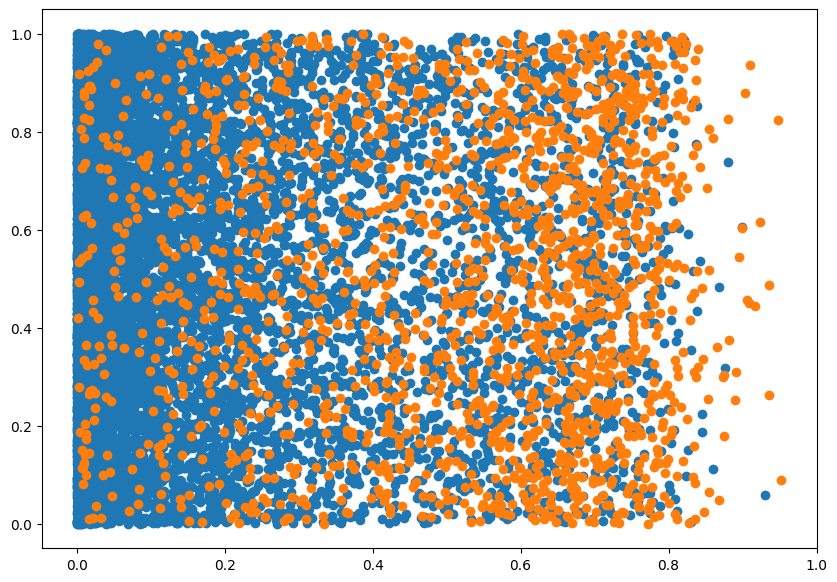

In [67]:
# xgb_model = XGBClassifier(scale_pos_weight = 2,max_depth = 2,eta = .4).fit(x_train, y_train)
xgb_model = XGBClassifier()
xgb_model.load_model('model_load.json')
prediction = xgb_model.predict_proba(x_test)[:,1]
plt.figure(figsize = (10,7))
plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))
plt.show()

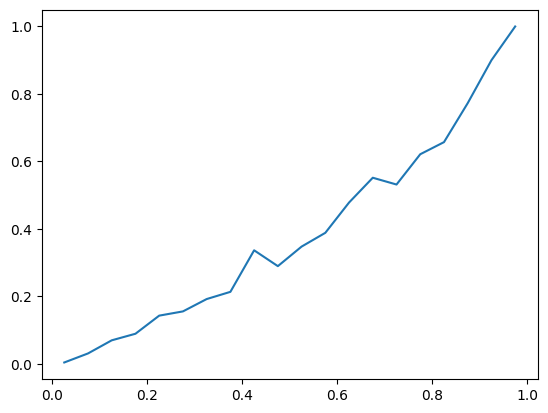

In [12]:
proba_plot(y_test,prediction,0.05)

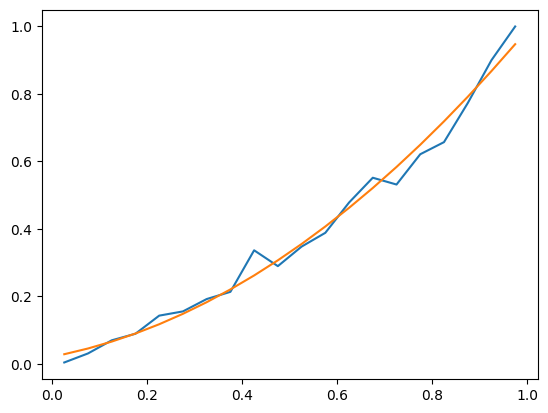

In [16]:
# xgb_model.save_model('model_load.json')
probx,proby = proba_data(y_test,prediction,0.05)
popt = curve_fit(square,probx,proby)[0]
curve_values = [square(x,*popt) for x in probx]
with open('coef.json','w') as file:
    json.dump(list(popt),file)
plt.plot(probx,proby)
plt.plot(probx,curve_values)
plt.show()

In [25]:
neural = load_model('model_DeepV1.h5')
xgb_model = XGBClassifier()
xgb_model.load_model('model_load.json')
coef = json.load(open('coef.json','r'))

In [26]:
class Arua:
    def __init__(self,model,popt):
        self.model = model
        self.func = np.vectorize(lambda x: square(x,*popt))
    def predict(self,x):
        if len(x.shape) == 1:
            return float(self.func(self.model.predict_proba(x.reshape(-1,17))[:,1][0]))
        return self.func(self.model.predict_proba(x)[:,1])
    
class Igor:
    def __init__(self,model):
        self.model = model
    def predict(self,x):
        if len(x.shape) == 1:
            return self.model.predict(x.reshape(-1,17))[0][0]
        return self.model.predict(x).ravel()

In [27]:
igor = Igor(neural)
arua = Arua(xgb_model,coef)

## Igor

In [31]:
tudo_x = np.concatenate((x_train,x_test))
tudo_y = np.concatenate((y_train,y_test))

817/817 [==============================] - 1s 1ms/step
Erro: 0.19478547398133714


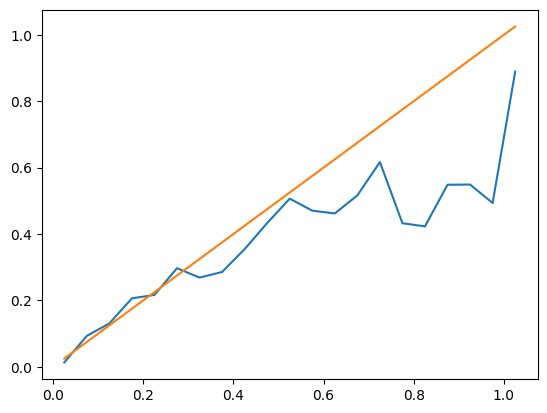

In [33]:
prediction = igor.predict(x_test)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Aruã

Erro: 0.14677995223857107


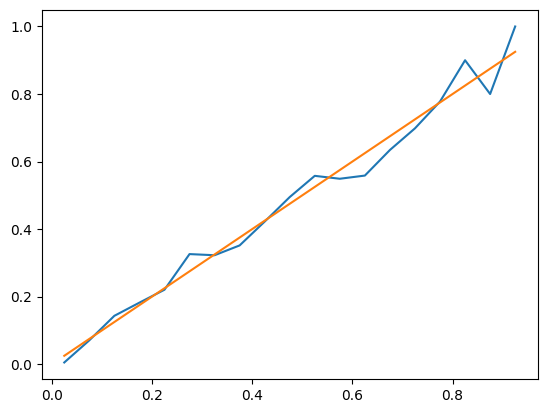

In [108]:
prediction = arua.predict(x_test)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Assembly simples

In [101]:
arua_pred = arua.predict(x_train)
igor_pred = igor.predict(x_train)
best_model = np.abs(igor_pred - y_train) < np.abs(arua_pred - y_train)

2449/2449 [==============================] - 3s 1ms/step


In [113]:
weight = best_model.sum() / len(best_model)
weight

0.8432255841553834

817/817 [==============================] - 1s 1ms/step
Erro: 0.13453259785654043


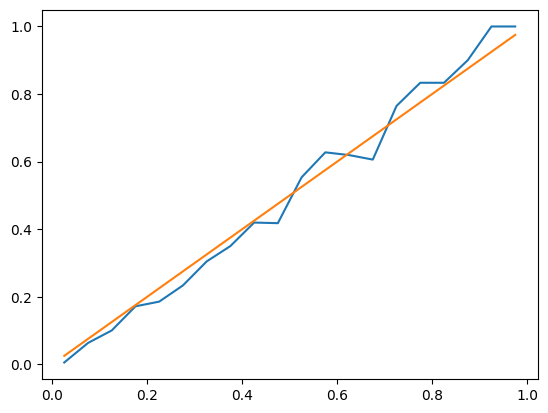

In [114]:
prediction = igor.predict(x_test) * weight + arua.predict(x_test) * (1 - weight)
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Assembly complexo

In [121]:
assembler = XGBClassifier(scale_pos_weight = 1,eta = .5,max_depth = 4).fit(x_train,best_model)

817/817 [==============================] - 1s 1ms/step
Erro: 0.13281086518826277


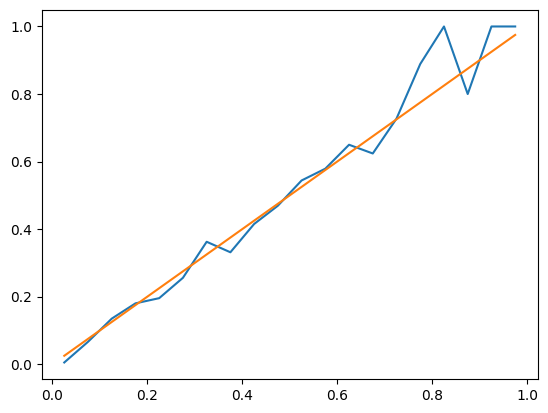

In [122]:
probas_assembler = assembler.predict_proba(x_test)
prediction = igor.predict(x_test) * probas_assembler[:,1] + arua.predict(x_test) * probas_assembler[:,0]
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()

## Specialized model

In [9]:
igor_pred = igor.predict(x_train)
igor_error = np.abs(igor_pred - y_train)

2449/2449 [==============================] - 3s 1ms/step


In [20]:
trashold = 0.005
filtro = igor_error > trashold
print('Percentage:',round(100 * filtro.sum() / len(filtro),2),'%')
x_specific,y_specific = x_train[filtro],y_train[filtro]
xgb_spec = XGBClassifier(scale_pos_weight = 2,max_depth = 2,eta = .4).fit(x_specific,y_specific)
prediction = xgb_spec.predict_proba(x_test)[:,1]
probx,proby = proba_data(y_test,prediction,0.05)
popt = curve_fit(square,probx,proby)[0]
arua_spec = Arua(xgb_spec,popt)

Percentage: 49.13 %


In [21]:
arua_pred = arua_spec.predict(x_train)
igor_pred = igor.predict(x_train)
best_model = np.abs(igor_pred - y_train) < np.abs(arua_pred - y_train)
print(best_model.sum() / len(best_model))

2449/2449 [==============================] - 3s 1ms/step
0.7581322341470885


In [22]:
assembler = XGBClassifier(scale_pos_weight = 1,eta = .5,max_depth = 4).fit(x_train,best_model)

817/817 [==============================] - 1s 1ms/step
Erro: 0.132601936920814


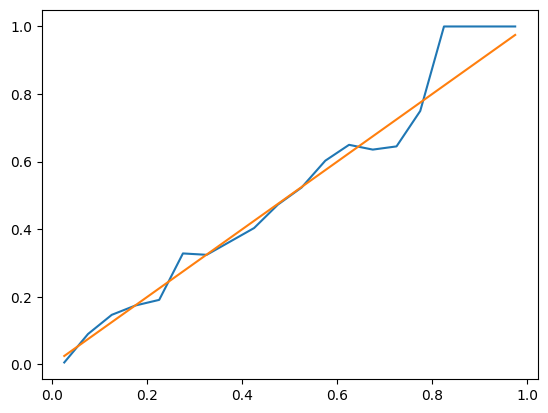

In [23]:
probas_assembler = assembler.predict_proba(x_test)
prediction = igor.predict(x_test) * probas_assembler[:,1] + arua_spec.predict(x_test) * probas_assembler[:,0]
probx,proby = proba_data(y_test,prediction,0.05)
print('Erro:',log_loss(y_test,prediction))
plt.plot(probx,proby)
plt.plot(probx,probx)
plt.show()